# EJERCICIO 2
# Clasificación de Imágenes

## Librerías

In [1]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from random import sample
from random import shuffle
from math import ceil as techo
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score 
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold, StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier

## Funciones

In [13]:
def CargaDatos(rutaObjects,verbose=False):
    def ordenaDirectorio(directorio, extension="jpg"):
        return sorted([os.path.join(directorio, f) for f in os.listdir(directorio) if f.endswith(extension)])
    animales = ['elephant', 'emu', 'flamingo', 'rhino']
    
    datos = {}
    for animal in animales:
        datos[animal] = ordenaDirectorio(f"{rutaObjects}/images/{animal}", extension="jpg"), ordenaDirectorio(f"{rutaObjects}/masks/{animal}", extension="png")

    print('Cargando datos...')
    if verbose: # vale para comprobar la biyección imagen-mascara
        for animal in datos:
            print(f'\nAnimal: {animal}')
            for imagen, mascara in zip(datos[animal][0], datos[animal][1]):
                print(f"Imagen: {os.path.basename(imagen)}, Máscara: {os.path.basename(mascara)}")
    return datos
#####################
def recortadoAleatorio(pixeles, minimo):
    indices = sorted(sample(range(len(pixeles)),minimo)) # ordena una seleccion sin repeticion de #minimo elementos de entre una lista de elementos de todos los numeros naturales que se corresponden con indices es la máscara
    return np.array([pixeles[indice] for indice in indices]).flatten() # selecciona en la imagen los elementos cuyos indices fueron seleccionados en la línea anterior
####################
def desordena(X,Y): # una funcion conveniente 
    temp = list(zip(X, Y))
    shuffle(temp)
    return zip(*temp)
    

#########################
def procesaImagen(imagen, mascara,numPixeles,pixeliza):
    
    def haz_histograma(pixeles):
        return np.array([np.histogram(pixelesEnMascara[:,color],bins=np.arange(256))[0] for color in range(3)]).flatten(order='F') # lo de order=F vale para que los tres histogramas esten concatenados y no entrelazados
    
    def MascaraGaussianoSobel(imagen,mascara,pixeliza):
        imagen = np.reshape([imagen[i][j] * mascara[i][j] for i in range(tamano[0]) for j in range(tamano[1])],(tamano[0],tamano[1],3))
        imagen = np.transpose([fila  for fila in np.transpose([fila  for fila in imagen if np.sum(fila) > 0 ],(1,0,2)) if np.sum(fila) > 0],(1,0,2)) # quita 
        imagen = cv2.GaussianBlur(imagen, (0, 0), 2, 2)
        imagen = cv2.Sobel(imagen, -1,1,0,ksize=3)
        return  cv2.resize(imagen, (int(tamano[1]*pixeliza),int(tamano[0]*pixeliza))).flatten() 

    
    
    imagen = cv2.imread(imagen)
    imagen = cv2.resize(imagen, (tamano[1],tamano[0])) # si lo pongo tal cual y luego hago imagen.shape devuelve (300, 200)

    mascara = cv2.imread(mascara, cv2.IMREAD_GRAYSCALE)
    mascara = cv2.resize(mascara, (tamano[1],tamano[0])) # si lo pongo tal cual y luego hago imagen.shape devuelve (300, 200)

        
    mascaraBinaria = mascara = (mascara > 0).astype(bool)  # Binarizar la máscara
    

    pixelesEnMascara = np.reshape(np.array([np.array(imagen[i][j]) for i in range(tamano[0]) for j in range(tamano[1]) if mascaraBinaria[i][j]]),(sum(sum(mascaraBinaria)),3))
    histograma = haz_histograma(pixelesEnMascara)
    algunosPixeles = recortadoAleatorio(pixelesEnMascara,numPixeles)
   
    if numPixeles:
        return [*histograma, *algunosPixeles, *MascaraGaussianoSobel(imagen,mascara,pixeliza)]
    else:
        return [*histograma]
###########################
def construyeDataset(datos,numPixeles,pixeliza,balancear=True):
    
    X = []
    Y = []

    print('Procesando datos...')
    for animal in datos:
        print(f'\nAnimal: {animal}')
        for imagen, mascara in zip(datos[animal][0], datos[animal][1]):
            X.append(procesaImagen(imagen, mascara,numPixeles,pixeliza)) # se le pasa la imagen la masacara y los hipeparametros a la funcion conveniente y se mete en X
            if animal == 'elephant': Y.append('E') # metemos en Y la etiqueta
            elif animal == 'rhino': Y.append('R')
            else: Y.append('O') # la O de Otros
                    
    
    X = np.array(X)

    if balancear: # si se balancea o si no se balancea es una decisión del usuario. Experimentalmente se consiguieron mejores resultados balanceando.
        X = list(X)
        Y = list(Y)
        nummin = min(Y.count('R'), Y.count('E'), Y.count('O')) # cuantos elementos tiene la clase mas pequeña
        contador = {'R': 0, 'E': 0, 'O': 0} # un contador que lo iniciamos a cero
        for i, clase in reversed(list(enumerate(Y))): # lo hago de atras hacia delante porque si borro por ejemplo el indice 127 luego al borrar el indice, por ejemplo, 233, reamente estoy borrando el 234
            contador[clase] += 1 # vamos recorriendo la lista de atras a delante, cada vez que nos encontramos un elemento lo añadimos uno al contador
            if contador[clase] > nummin: # en el momento en que un contador exceda nummin significa que estamos ante un elemento que deberíamos borrar para que en todas las clases haya el mismo número de elementos
                 del X[i], Y[i] # lo borramos
    return X, Y 

def separaEntrenamientoTest(X,Y, razon=0.8,unoFuera=False):
    X, Y = desordena(X, Y)
    
    if unoFuera:
        X_entrenamiento = X[:-2]
        X_test =          np.array(X[-1]).reshape(1, -1)
        Y_entrenamiento = Y[:-2]
        Y_test =          np.array(Y[-1]).reshape(1, -1)
        return X_entrenamiento, Y_entrenamiento, X_test, Y_test
    
    X_entrenamiento = X[:techo(len(X)*razon) ]
    X_test =          X[ techo(len(X)*razon):]
    Y_entrenamiento = Y[:techo(len(X)*razon) ]
    Y_test =          Y[ techo(len(X)*razon):]
    return X_entrenamiento, Y_entrenamiento, X_test, Y_test

def plot_listaDeAccuracy(listaDeAccuracy):
    
    media = round(np.mean(listaDeAccuracy),2)
    sigma = round(np.sqrt(np.var(listaDeAccuracy)),2)
    mediana = round(np.median(listaDeAccuracy),2)
    
    plt.figure(figsize = (10, 5))
    plt.axvline(x = .5, color = '#8fbcbb',label='0.5')
    plt.axvline(x = media, color = '#81a1c1',label='media de accuracy')
    plt.axvline(x = media + sigma , color = '#a3be8c',label='+σ')
    plt.axvline(x = media - sigma, color = '#a3be8c',label='-σ')
    plt.axvline(x = mediana, color = '#ebcb8b',label='mediana')
    
    plt.hist(listaDeAccuracy,color='#4c566a',bins=10)
    plt.legend()
    
    print(f'Acuracy de {media} ± {sigma}. Se usaron {N} intentos.')

## Código Principal

In [9]:
tamano = (200, 300)

datos = CargaDatos('../../objects')

X, Y = construyeDataset(datos,numPixeles=1500, pixeliza=1, balancear=True)

Cargando datos...
Procesando datos...

Animal: elephant

Animal: emu

Animal: flamingo

Animal: rhino


## Un entrenamiento

In [10]:
X_entrenamiento, Y_entrenamiento, X_test, Y_test = separaEntrenamientoTest(X,Y,razon=0.8)
#X_entrenamiento, Y_entrenamiento, X_test, Y_test = separaEntrenamientoTest(X,Y,unoFuera=True)

modelo_svm = svm.SVC(kernel='rbf')
modelo_svm.fit(X_entrenamiento,Y_entrenamiento)
Y_predicho = modelo_svm.predict(X_test)
print(classification_report(Y_test,Y_predicho))

              precision    recall  f1-score   support

           E       0.75      0.75      0.75        12
           O       0.90      0.90      0.90        10
           R       0.85      0.85      0.85        13

    accuracy                           0.83        35
   macro avg       0.83      0.83      0.83        35
weighted avg       0.83      0.83      0.83        35



## Distribución del accuracy

In [11]:
listaDeAccuracy = []
N = 150
for i in range(N):
    X_entrenamiento, Y_entrenamiento, X_test, Y_test = separaEntrenamientoTest(X,Y,razon=0.9)
    #X_entrenamiento, Y_entrenamiento, X_test, Y_test = separaEntrenamientoTest(X,Y,unoFuera=True)
    modelo_svm = svm.SVC(kernel='rbf')
    modelo_svm.fit(X_entrenamiento,Y_entrenamiento)
    Y_predicho = modelo_svm.predict(X_test)
    listaDeAccuracy.append(accuracy_score(Y_test,Y_predicho))

Acuracy de 0.86 ± 0.09. Se usaron 150 intentos.


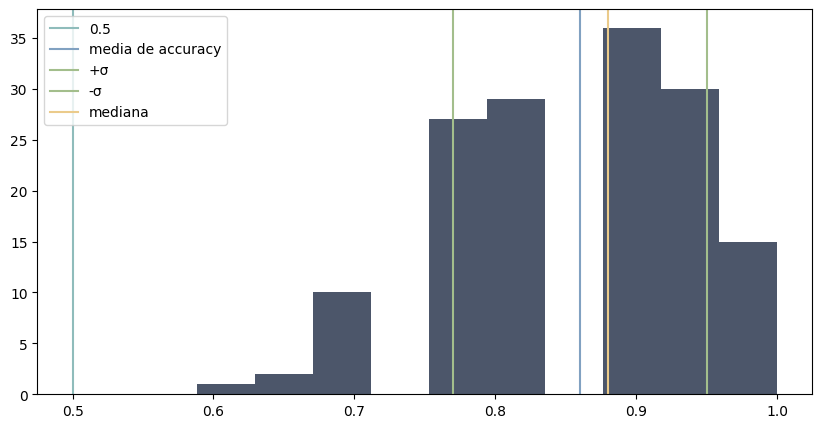

In [14]:
plot_listaDeAccuracy(listaDeAccuracy)

# Metodología empleada

## Procesado. De imágenes a vectores

Se empieza a narrar la práctica desde que tenemos las imágenes leidas, y estan almacenadas como tensores $[m\times n\times 3]$. Para detalles en la implementación ver ```CargaDatos(ruta)```. A partir de ahí hacemos transformaciones sobre esos tensores para conseguir vectores cuyos elementos representen lo más posible a la clase de la imagen $\{$ rinoceronte, elefante, otros. $\}$. Se probaron múltiples opciones y combinaciones, a continuación se presentan las componentes del vector(se puede encontrar todo el código):
 - Histograma: Un vector de $3\times 256$ elementos donde el elemento $i + 256\times j$ es la cantidad de pixeles de el color $j$ con la intensidad $i$. Para más detalles ver `haz_histograma(pixeles)`.
 - Algunos pixeles: Una seleccion aleatoria (pero en orden) de algunos de los pixeles de la imagen original tales que están dentro de la máscara. Experimentos han demostrado que algunos pixeles ofrecen mejor rendimiento que ningún pixel. Aunque la distrubución de probabilidad marginal de que un pixel sea de un color ya se tiene con el histograma, estos píxeles ofrecen alguna característica que ayuda a diferenciar mejor. La decisión actual sobre el numero de pixeles es $1000$. Para más detalles ver `recortadoAleatorio(pixeles, minimo)`.
 - Sobel de la gausiana con máscara: A la imagen original se le aplica la máscara de forma que todos los pixeles de fuera de la máscara valgan 0, después se le aplica un filtro gausiano que emborrona la imagen y facilita la tarea del Sobel. Esto es porque Sobel no puede diferenciar fácilmente entre un borde semántico y una variación muy fuerte y repentina en la función $f(x,y)$ de la imagen, pero el filtro gausiano reduce la influencia de estas anomalías. Posteriormente aplicamos el filtro Sobel y devolvemos la imagen. Como la imagen es de $(200\times 300)$, este tercer punto merece ser revisado, con el objetivo de poder comprimir el número de elementos del vector. Para detalles en implementación ver `MascaraGaussianoSobel(imagen,mascara,padin,pixeliza)`. Se exploró:
     - Recortar la imagen: Después de aplicar la máscara los píxeles que no pertenecen a ella valen cero. Las máscaras son de los objetos. Los objetos suelen estar en el medio de la imagen. Con esta suposición inferimos que después de aplicar la máscara, esta estará rodeada de píxeles negros, lo cual no aporta información y en general podemos decir que _molesta_. Motivados por esta creencia recortamos la imagen descartando las primeras y últimas filas y columnas. Esto lo hicimos mediante dos aproximaciones.
         - En primer lugar decidimos usar un recorte fijo. Buscando cuantos pixeles recortar nos llevamos una sorpresa cuando vimos las graficas de abajo, porque se ve que el rendimiento no mejora segun recortamos.
         - Para arreglarlo hicimos un recorte dinámico. Esto ofreció muy buenos resultados.
     - Bajar la resolución: Como son muchos píxeles y sólo nos estamos fijando en los bordes (estamos aplicando Sobel), parece que no es muy necesaria la precision, por eso decidimos implementar la posibilidad de reducir la resolución de la imagen. Experimentalmente encontramos que la resolución original es la mejor (aunque ello conlleve un gran número de elementos), es decir, `pixeliza = 1`. Como 

La forma en la que lo previo se relaciona puede verse en `procesaImagen(imagen,mascara,numPixeles,padin,pixeliza)` y en `construyeDataset(datos,numPixeles,padin,pixeliza,balancear=True)`. 

![h](../figuras/accuracyrecorte35.png)
![h](../figuras/accuracyrecorte50.png)

## Aprendizaje. De vectores a clases
### Algoritmo
La librería de Python Scikit Learn fue ampliamente explorada porque ante la pregunta ¿Qué algoritmo debería usar? la mejor respuesta fue usar varios y compararlos. Ganó entre ellos la máquina de soporte vectorial con kernel radial. Se exploró con valores de `gamma` sólo para apreciar una ligera mejora. No vale la pena perder tiempo con eso. En el resultado final no se especifíca nada más que el kernel.

### Presentación
 - Un entrenamiento con sus métricas (F1, precision, recall, accuracy) se presenta arriba en el cuarderno. Si bien es cierto que una métrica puede ser engañosa, el conjunto de todas ellas parece insinuar que el entrenamiento fue correcto.
 - Adicionalmente se presenta un bucle de entrenamientos en los que se guarda el accuracy de cada uno de ellos y se presenta estadística descriptiva que avala que el entrenamiento anterior no ocurrio favorablemente _de chiripa_.
 - Como esto es un cuaderno, ¡Te invito a que lo ejecutes y pruebes tu mismo! De esta forma verás que lo que digo es cierto y además el efecto de cambiar los hiperparámetros.

In [ ]:
arr = np.array([[0,0],[0,1]])

In [ ]:
sum(arr)

In [ ]:
 def MascaraGaussianoSobel(imagen,mascara,pixeliza):
        imagen = np.reshape([imagen[i][j] * mascara[i][j] for i in range(tamano[0]) for j in range(tamano[1])],(tamano[0],tamano[1],3))
        imagen = np.transpose([fila  for fila in np.transpose([fila  for fila in imagen if np.sum(fila) > 0 ],(1,0,2)) if np.sum(fila) > 0],(1,0,2)) # quita 
        imagen = cv2.GaussianBlur(imagen, (0, 0), .3, .3)
        imagen = cv2.Sobel(imagen, -1,1,0,ksize=1)
        imagen[imagen< 20] = 0

        return  cv2.resize(imagen, (int(tamano[1]*pixeliza),int(tamano[0]*pixeliza)))


In [ ]:
imagenPrueba = cv2.imread('../../objects/images/elephant/image_0002.jpg')
mascaraPrueba = cv2.imread('../../objects/masks/elephant/mask_0002.png')

xd = MascaraGaussianoSobel(imagenPrueba,mascaraPrueba,1)
tamano = (200, 300)
imagenPrueba = cv2.resize(imagenPrueba, (tamano[1],tamano[0]))
imagenPrueba = np.reshape([imagenPrueba[i][j] * mascaraPrueba[i][j] for i in range(tamano[0]) for j in range(tamano[1])],(tamano[0],tamano[1],3))
imagenPrueba = np.transpose([fila  for fila in np.transpose([fila  for fila in imagenPrueba if np.sum(fila) > 0 ],(1,0,2)) if np.sum(fila) > 0],(1,0,2)) # quita as filas negras de ella y de. su transpuesta


In [ ]:
plt.imshow(xd,cmap='gray');


In [ ]:
tamano = (200, 300)

datos = CargaDatos('../../objects')
X, Y = construyeDataset(datos,numPixeles=1500, padin=10, pixeliza=1, balancear=True)



N = 60
l=[]
for i in np.linspace(0.6,1,10):
    print(i)
    acuracis = []
    for _ in range(N):
        print(_,end=' ')
        
        
        X_entrenamiento, Y_entrenamiento, X_test, Y_test = separaEntrenamientoTest(X,Y,razon=0.9)
        #X_entrenamiento, Y_entrenamiento, X_test, Y_test = separaEntrenamientoTest(X,Y,unoFuera=True)
        
        modelo_svm = svm.SVC(kernel='rbf')
        modelo_svm.fit(X_entrenamiento,Y_entrenamiento, sample_weight=)
        Y_predicho = modelo_svm.predict(X_test)
        
        acuracis.append(accuracy_score(Y_test,Y_predicho))


    media = round(np.mean(acuracis),2)
    sigma = round(np.sqrt(np.var(acuracis)),2)
    mediana = round(np.median(acuracis),2)

    l.append([i,media,sigma,mediana])

l = np.array([list(l[i]) for i in range(len(l))])
'''
plt.plot(l[:,0],label='media acuracy')
plt.plot(l[:,1],label='sigma')
plt.plot(l[:,2],label='mediana')
plt.xlabel("grosor del recorte en pixeles")
plt.legend();
'''

In [ ]:
l = np.array(l)
lin = l[:,0]
media = l[:,1]
sd = l[:,2]
mediana = l[:,3]
plt.plot(lin,media)
#plt.plot(lin,sd)
plt.plot(lin,mediana)

In [ ]:
l

In [ ]:
pesoHistograma

In [ ]:
np.array([np.ones(4)*2,np.ones(4)])